<a href="https://colab.research.google.com/github/MthabisiPatrice/Machine-Learning-/blob/main/taxi_hack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Description

This dataset is designed to predict taxi trip fares based on various factors such as distance, time of day, traffic conditions, and more. It provides realistic synthetic data for regression tasks, offering a unique opportunity to explore pricing trends in the taxi industry.

Key Features

Distance (in kilometers): The length of the trip.
Pickup Time: The starting time of the trip.
Dropoff Time: The ending time of the trip.
Traffic Condition: Categorical indicator of traffic (light, medium, heavy).
Passenger Count: Number of passengers for the trip.
Weather Condition: Categorical data for weather (clear, rain, snow).
Trip Duration (in minutes): Total trip time.
Fare Amount (target): The cost of the trip (in USD).

In [3]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib import pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn import tree
from sklearn.metrics import mean_squared_error
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, r2_score
import altair as alt
from geopy.distance import geodesic
import math

In [4]:
taxi = pd.read_csv('/content/taxi_data.csv')

In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


In [6]:
import pandas as pd

# Fill missing values for numerical columns with their mean
taxi['Trip_Distance_km'] = taxi['Trip_Distance_km'].fillna(taxi['Trip_Distance_km'].mean())
taxi['Passenger_Count'] = taxi['Passenger_Count'].fillna(taxi['Passenger_Count'].mean())
taxi['Base_Fare'] = taxi['Base_Fare'].fillna(taxi['Base_Fare'].mean())
taxi['Per_Km_Rate'] = taxi['Per_Km_Rate'].fillna(taxi['Per_Km_Rate'].mean())
taxi['Per_Minute_Rate'] = taxi['Per_Minute_Rate'].fillna(taxi['Per_Minute_Rate'].mean())
taxi['Trip_Duration_Minutes'] = taxi['Trip_Duration_Minutes'].fillna(taxi['Trip_Duration_Minutes'].mean())
taxi['Trip_Price'] = taxi['Trip_Price'].fillna(taxi['Trip_Price'].mean())

# Fill missing values for categorical columns with their mode (most frequent value)
taxi['Time_of_Day'] = taxi['Time_of_Day'].fillna(taxi['Time_of_Day'].mode()[0])
taxi['Day_of_Week'] = taxi['Day_of_Week'].fillna(taxi['Day_of_Week'].mode()[0])
taxi['Traffic_Conditions'] = taxi['Traffic_Conditions'].fillna(taxi['Traffic_Conditions'].mode()[0])
taxi['Weather'] = taxi['Weather'].fillna(taxi['Weather'].mode()[0])

# Check the result
print(taxi.isnull().sum())



Trip_Distance_km         0
Time_of_Day              0
Day_of_Week              0
Passenger_Count          0
Traffic_Conditions       0
Weather                  0
Base_Fare                0
Per_Km_Rate              0
Per_Minute_Rate          0
Trip_Duration_Minutes    0
Trip_Price               0
dtype: int64


In [7]:
taxi.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.350000,Morning,Weekday,3.0,Low,Clear,3.560000,0.80,0.32,53.82,36.262400
1,47.590000,Afternoon,Weekday,1.0,High,Clear,3.502989,0.62,0.43,40.57,56.874773
2,36.870000,Evening,Weekend,1.0,High,Clear,2.700000,1.21,0.15,37.27,52.903200
3,30.330000,Evening,Weekday,4.0,Low,Clear,3.480000,0.51,0.15,116.81,36.469800
4,27.070547,Evening,Weekday,3.0,High,Clear,2.930000,0.63,0.32,22.64,15.618000


In [8]:
# first we see the kind of data before
for column in ['Traffic_Conditions', 'Time_of_Day', 'Day_of_Week', 'Weather']:
    unique_values = taxi[column].unique()
    print(f"Unique values in '{column}': {unique_values}")

Unique values in 'Traffic_Conditions': ['Low' 'High' 'Medium']
Unique values in 'Time_of_Day': ['Morning' 'Afternoon' 'Evening' 'Night']
Unique values in 'Day_of_Week': ['Weekday' 'Weekend']
Unique values in 'Weather': ['Clear' 'Rain' 'Snow']


In [9]:
#now we onehot encode the nonsensical data.
one_hot_encoded_data = pd.get_dummies(taxi, columns=['Traffic_Conditions', 'Time_of_Day', 'Day_of_Week', 'Weather'])

In [10]:
taxi_encoded = one_hot_encoded_data

In [11]:
#creating a
x = taxi_encoded.drop('Trip_Price', axis=1)
y = taxi_encoded['Trip_Price']

In [12]:
#train the model.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [13]:
# convert data to d matrix
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [14]:
#define the parameters

xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.5,
    learning_rate=0.1,
    max_depth=4,
    alpha=2,
    n_estimators=500,
    subsample=0.8,
    min_child_weight=5,
    gamma=2
)

In [15]:
#train the model

model = xg_reg.fit(x_train, y_train)

In [19]:
model

XGBRegressor(alpha=2, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, ...)

In [17]:
#predictions
predictions = model.predict(x_test)

In [20]:
#feature importance
feature_importance = model.feature_importances_
feature_names = x_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)


                      Feature  Importance
0            Trip_Distance_km    0.526371
3                 Per_Km_Rate    0.070157
7      Traffic_Conditions_Low    0.062880
5       Trip_Duration_Minutes    0.058037
6     Traffic_Conditions_High    0.046400
4             Per_Minute_Rate    0.038627
1             Passenger_Count    0.023427
11        Time_of_Day_Morning    0.023262
14        Day_of_Week_Weekend    0.022285
15              Weather_Clear    0.022267
10        Time_of_Day_Evening    0.020381
2                   Base_Fare    0.017380
13        Day_of_Week_Weekday    0.016396
9       Time_of_Day_Afternoon    0.013523
16               Weather_Rain    0.013232
8   Traffic_Conditions_Medium    0.011977
12          Time_of_Day_Night    0.009749
17               Weather_Snow    0.003649


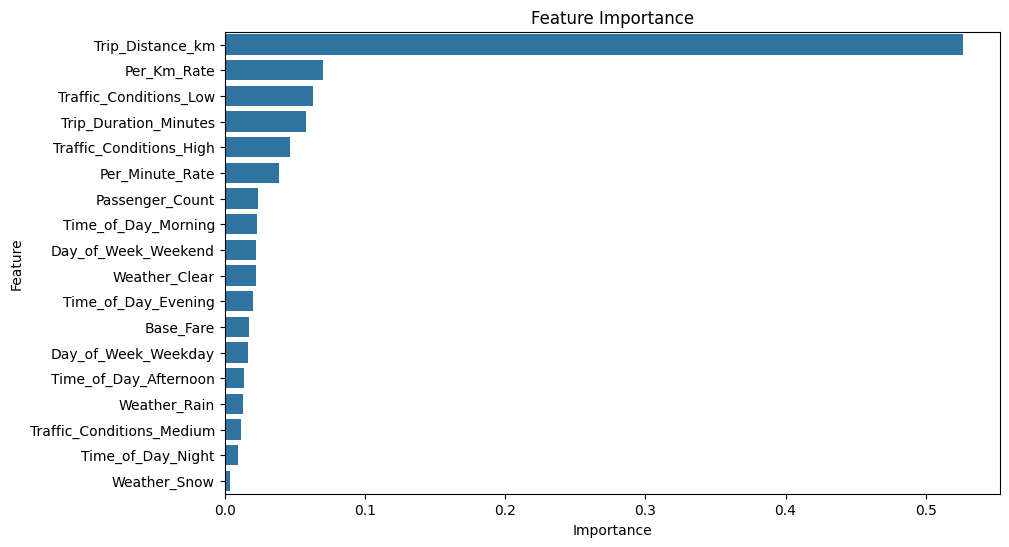

In [21]:
#graph feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [18]:
#model perfomance
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 70.139769384495
R-squared: 0.9155313019204472


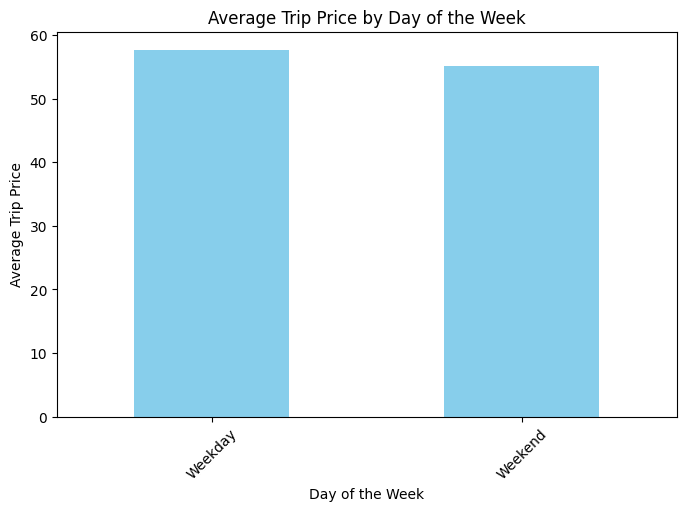

In [22]:
#stats

import pandas as pd
import matplotlib.pyplot as plt

# Group by Day_of_Week and calculate the average Trip_Price
avg_price_day = taxi.groupby('Day_of_Week')['Trip_Price'].mean()

# Plot the bar chart
plt.figure(figsize=(8, 5))
avg_price_day.plot(kind='bar', color='skyblue')
plt.title('Average Trip Price by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Trip Price')
plt.xticks(rotation=45)
plt.show()


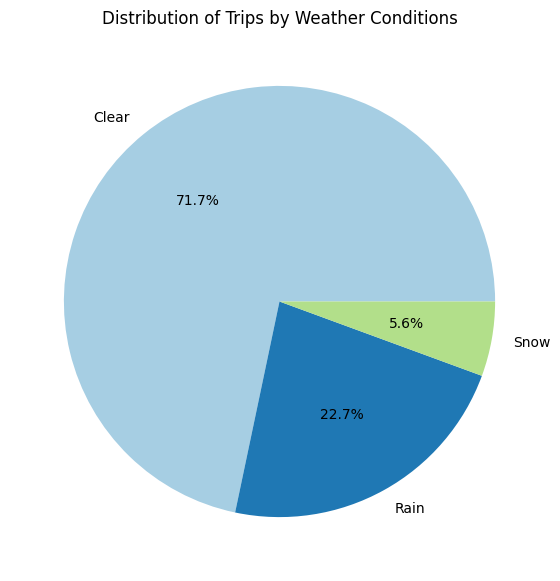

In [24]:
# Group by Weather and count the number of trips
weather_dist = taxi['Weather'].value_counts()

# Plot the pie chart
plt.figure(figsize=(7, 7))
plt.pie(weather_dist, labels=weather_dist.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Distribution of Trips by Weather Conditions')
plt.show()


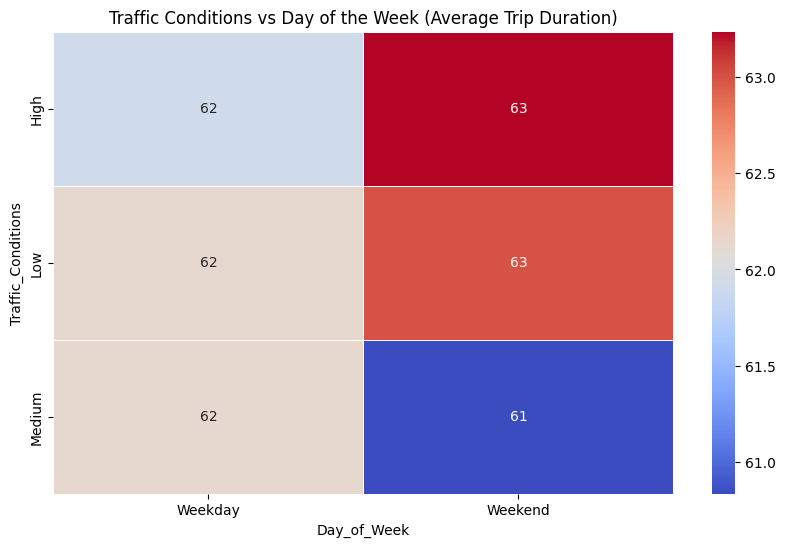

In [25]:
import seaborn as sns

# pivot table with Traffic_Conditions as rows, Day_of_Week as columns, and average Trip_Duration_Minutes as values
heatmap_data = taxi.pivot_table(index='Traffic_Conditions', columns='Day_of_Week', values='Trip_Duration_Minutes', aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Traffic Conditions vs Day of the Week (Average Trip Duration)')
plt.show()


In [26]:
# Generate summary statistics for key columns
summary_stats = taxi[['Trip_Price', 'Trip_Distance_km', 'Trip_Duration_Minutes']].agg(['mean', 'median', 'std', 'min', 'max'])

# Display the summary table
print(summary_stats)


        Trip_Price  Trip_Distance_km  Trip_Duration_Minutes
mean     56.874773         27.070547              62.118116
median   52.617000         26.995000              62.118116
std      39.464810         19.400775              31.339413
min       6.126900          1.230000               5.010000
max     332.043689        146.067047             119.840000
